In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn import linear_model 
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

### Preparing data

In [2]:
rate_2017 = pd.read_excel("data/2017.xlsx")
rate_2018 = pd.read_excel("data/2018.xlsx")
rate_2019 = pd.read_excel("data/2019.xlsx")
rate_2020 = pd.read_excel("data/2020.xlsx")
rate_2021 = pd.read_excel("data/2021.xlsx")
rate_2017 = rate_2017.drop([rate_2017.shape[0]-1, rate_2017.shape[0]-2, rate_2017.shape[0]-3, rate_2017.shape[0]-4, 0])
rate_2018 = rate_2018.drop([rate_2018.shape[0]-1, rate_2018.shape[0]-2, rate_2018.shape[0]-3, rate_2018.shape[0]-4, 0])
rate_2019 = rate_2019.drop([rate_2019.shape[0]-1, rate_2019.shape[0]-2, rate_2019.shape[0]-3, rate_2019.shape[0]-4, 0])
rate_2020 = rate_2020.drop([rate_2020.shape[0]-1, rate_2020.shape[0]-2, rate_2020.shape[0]-3, rate_2020.shape[0]-4, 0])
rate_2021 = rate_2021.drop([rate_2021.shape[0]-1, rate_2021.shape[0]-2, rate_2021.shape[0]-3, rate_2021.shape[0]-4, 0])
final_df = rate_2017.append(rate_2018).append(rate_2019).append(rate_2020).append(rate_2021)
final_df = final_df.drop(columns=['1 XDR', 'pełny numer tabeli', 'nr tabeli'])

In [3]:
final_df

,data,1 THB,1 USD,1 AUD,1 HKD,1 CAD,1 NZD,1 SGD,1 EUR,100 HUF,...,1 PHP,1 MXN,1 ZAR,1 BRL,1 MYR,1 RUB,10000 IDR,100 INR,100 KRW,1 CNY
1,2017-01-02 00:00:00,0.1175,4.2106,3.0187,0.5428,3.1402,2.9146,2.9039,4.4157,1.427,...,0.0847,0.2036,0.3062,1.2938,0.9387,0.0687,3.1255,6.1827,0.3487,0.6063
2,2017-01-03 00:00:00,0.1178,4.2271,3.0477,0.5453,3.1494,2.9309,2.9163,4.4002,1.4226,...,0.085,0.2041,0.3072,1.2875,0.9416,0.0695,3.1382,6.1887,0.3504,0.6082
3,2017-01-04 00:00:00,0.1174,4.2037,3.0539,0.542,3.1429,2.9167,2.9079,4.3877,1.4207,...,0.0847,0.199,0.3082,1.2873,0.9346,0.0691,3.1275,6.166,0.3498,0.6065
4,2017-01-05 00:00:00,0.1164,4.1667,3.0375,0.5373,3.1329,2.9052,2.9056,4.3766,1.4175,...,0.0841,0.1945,0.3044,1.2954,0.9289,0.0691,3.1149,6.1327,0.3506,0.6051
5,2017-01-09 00:00:00,0.1164,4.1592,3.0423,0.5364,3.14,2.8973,2.8864,4.3783,1.421,...,0.0839,0.1952,0.302,1.2902,0.9292,0.0694,3.1125,6.0979,0.345,0.5999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2021-10-07 00:00:00,0.1164,3.9334,2.867,0.5053,3.1247,2.7236,2.897,4.5472,1.2688,...,0.0779,0.1919,0.2638,0.716,0.9402,0.0544,2.7668,5.2633,0.3304,0.6066
196,2021-10-08 00:00:00,0.1175,3.9775,2.9015,0.5109,3.1704,2.7514,2.929,4.5956,1.2784,...,0.0787,0.1925,0.2661,0.7207,0.9513,0.0552,2.7966,5.3046,0.3326,0.6169
197,2021-10-11 00:00:00,0.1178,3.9862,2.9273,0.5123,3.202,2.7714,2.9459,4.612,1.2756,...,0.0785,0.1924,0.2668,0.7238,0.9563,0.0557,2.8057,5.2917,0.3337,0.6191
198,2021-10-12 00:00:00,0.1186,3.9664,2.9199,0.5097,3.1817,2.7595,2.924,4.5859,1.2742,...,0.078,0.1902,0.2641,0.7163,0.9517,0.0552,2.7898,5.2524,0.3311,0.6144


In [4]:
final_df.columns = final_df.columns.str.replace('1 ', '')
final_df.columns = final_df.columns.str.replace('100 JPY', 'JPY_100')

In [5]:
#Checking if there are NaN values
final_df.isna().sum()

data         0
THB          0
USD          0
AUD          0
HKD          0
CAD          0
NZD          0
SGD          0
EUR          0
100 HUF      0
CHF          0
GBP          0
UAH          0
JPY_100      0
CZK          0
DKK          0
100 ISK      0
NOK          0
SEK          0
HRK          0
RON          0
BGN          0
TRY          0
ILS          0
100 CLP      0
PHP          0
MXN          0
ZAR          0
BRL          0
MYR          0
RUB          0
10000 IDR    0
100 INR      0
100 KRW      0
CNY          0
dtype: int64

In [6]:
final_df.dtypes

data         object
THB          object
USD          object
AUD          object
HKD          object
CAD          object
NZD          object
SGD          object
EUR          object
100 HUF      object
CHF          object
GBP          object
UAH          object
JPY_100      object
CZK          object
DKK          object
100 ISK      object
NOK          object
SEK          object
HRK          object
RON          object
BGN          object
TRY          object
ILS          object
100 CLP      object
PHP          object
MXN          object
ZAR          object
BRL          object
MYR          object
RUB          object
10000 IDR    object
100 INR      object
100 KRW      object
CNY          object
dtype: object

In [7]:
#Setting one data type (float) for every column apart from data
for col in final_df.columns[1:]:
    final_df[col] = pd.to_numeric(final_df[col], errors='coerce')

In [8]:
final_df

,data,THB,USD,AUD,HKD,CAD,NZD,SGD,EUR,100 HUF,...,PHP,MXN,ZAR,BRL,MYR,RUB,10000 IDR,100 INR,100 KRW,CNY
1,2017-01-02 00:00:00,0.1175,4.2106,3.0187,0.5428,3.1402,2.9146,2.9039,4.4157,1.4270,...,0.0847,0.2036,0.3062,1.2938,0.9387,0.0687,3.1255,6.1827,0.3487,0.6063
2,2017-01-03 00:00:00,0.1178,4.2271,3.0477,0.5453,3.1494,2.9309,2.9163,4.4002,1.4226,...,0.0850,0.2041,0.3072,1.2875,0.9416,0.0695,3.1382,6.1887,0.3504,0.6082
3,2017-01-04 00:00:00,0.1174,4.2037,3.0539,0.5420,3.1429,2.9167,2.9079,4.3877,1.4207,...,0.0847,0.1990,0.3082,1.2873,0.9346,0.0691,3.1275,6.1660,0.3498,0.6065
4,2017-01-05 00:00:00,0.1164,4.1667,3.0375,0.5373,3.1329,2.9052,2.9056,4.3766,1.4175,...,0.0841,0.1945,0.3044,1.2954,0.9289,0.0691,3.1149,6.1327,0.3506,0.6051
5,2017-01-09 00:00:00,0.1164,4.1592,3.0423,0.5364,3.1400,2.8973,2.8864,4.3783,1.4210,...,0.0839,0.1952,0.3020,1.2902,0.9292,0.0694,3.1125,6.0979,0.3450,0.5999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2021-10-07 00:00:00,0.1164,3.9334,2.8670,0.5053,3.1247,2.7236,2.8970,4.5472,1.2688,...,0.0779,0.1919,0.2638,0.7160,0.9402,0.0544,2.7668,5.2633,0.3304,0.6066
196,2021-10-08 00:00:00,0.1175,3.9775,2.9015,0.5109,3.1704,2.7514,2.9290,4.5956,1.2784,...,0.0787,0.1925,0.2661,0.7207,0.9513,0.0552,2.7966,5.3046,0.3326,0.6169
197,2021-10-11 00:00:00,0.1178,3.9862,2.9273,0.5123,3.2020,2.7714,2.9459,4.6120,1.2756,...,0.0785,0.1924,0.2668,0.7238,0.9563,0.0557,2.8057,5.2917,0.3337,0.6191
198,2021-10-12 00:00:00,0.1186,3.9664,2.9199,0.5097,3.1817,2.7595,2.9240,4.5859,1.2742,...,0.0780,0.1902,0.2641,0.7163,0.9517,0.0552,2.7898,5.2524,0.3311,0.6144


In [9]:
#Reading and dformatting resources
gold= pd.read_csv("data/złoto.csv")
gold['gold'] = gold['Ostatnio']
gold = gold.drop(columns=['Otwarcie', 'Max.', 'Min.', 'Wol.', 'Zmiana%', 'Ostatnio'])
silver = pd.read_csv("data/srebro.csv")
silver['silver'] = silver['Ostatnio']
silver = silver.drop(columns=['Otwarcie', 'Max.', 'Min.', 'Wol.', 'Zmiana%', 'Ostatnio'])
oil= pd.read_csv("data/ropa_WTI.csv")
oil['oil'] = oil['Ostatnio']
oil = oil.drop(columns=['Otwarcie', 'Max.', 'Min.', 'Wol.', 'Zmiana%', 'Ostatnio'])
resources = pd.merge(gold, silver, on=["Data"])
resources = pd.merge(resources, oil, on=["Data"])
resources = resources.iloc[::-1].reset_index(drop=True)
resources.Data = pd.to_datetime(resources.Data, dayfirst=True)
resources = resources.rename(columns={'Data':'data'})
resources['gold'] = resources['gold'].str.replace('.','')
for col in resources.columns[1:]:
    resources[col] = resources[col].str.replace(',','.')
    resources[col] = resources[col].astype(float)
#resources['month_year'] = resources['data'].dt.to_period('M')

C:\Users\konra\AppData\Local\Temp/ipykernel_19864/3421079568.py:16: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  resources['gold'] = resources['gold'].str.replace('.','')


In [10]:
resources.dtypes

data      datetime64[ns]
gold             float64
silver           float64
oil              float64
dtype: object

In [11]:
resources

,data,gold,silver,oil
0,2017-01-02,1151.05,16.015,54.03
1,2017-01-03,1244.70,17.810,52.33
2,2017-01-04,1247.10,17.955,53.26
3,2017-01-05,1262.10,18.037,53.76
4,2017-01-06,1255.70,17.921,53.99
...,...,...,...,...
1256,2021-10-07,1761.10,22.658,78.30
1257,2021-10-08,1759.40,22.705,79.35
1258,2021-10-11,1757.70,22.665,80.52
1259,2021-10-12,1761.20,22.514,80.64


In [12]:
chf_with_dates = final_df[["data", "CHF"]]
chf_with_dates = chf_with_dates.set_index('data')

In [13]:
final_df = final_df.reset_index(drop=True)
resources = resources.set_index('data')
final_df = final_df.set_index('data')
#preparing dataframe containing all variables
resources_currency = pd.merge(final_df, resources, left_index=True, right_index=True)

# Data analysis

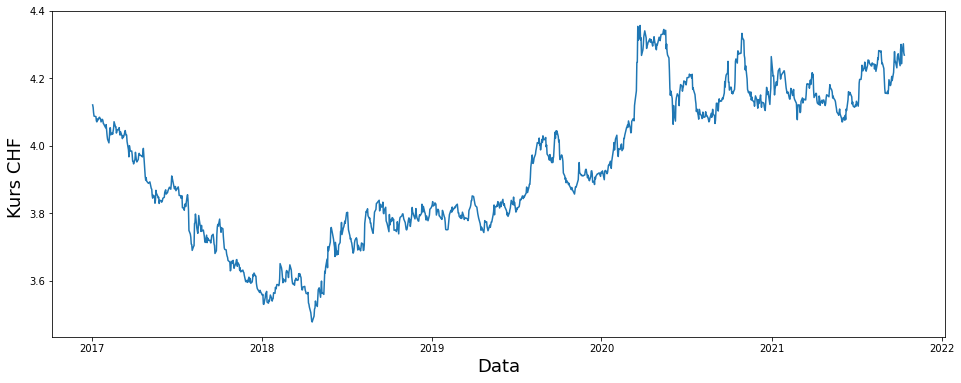

In [14]:
#Visualize the data
plt.figure(figsize=(16,6))
plt.xlabel('Data', fontsize=18)
plt.ylabel('Kurs CHF ', fontsize=18)
plt.plot(final_df['CHF'])
plt.savefig('chf.png')

In [15]:
final_df['CHF'].describe()

count    1208.000000
mean        3.934916
std         0.215910
min         3.477700
25%         3.774700
50%         3.910300
75%         4.130700
max         4.356300
Name: CHF, dtype: float64

Median:  3.9103000000000003
Varaiance:  0.04661694817564621


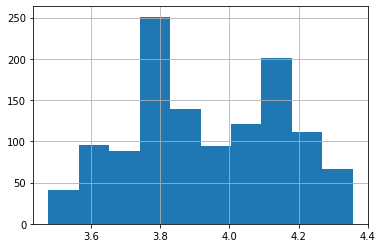

In [16]:
print("Median: ", final_df['CHF'].median())
print("Varaiance: ", final_df['CHF'].var())
final_df['CHF'].hist()
plt.savefig('histogram.png')

In [17]:
resources

,gold,silver,oil
data,,,
2017-01-02,1151.05,16.015,54.03
2017-01-03,1244.70,17.810,52.33
2017-01-04,1247.10,17.955,53.26
2017-01-05,1262.10,18.037,53.76
2017-01-06,1255.70,17.921,53.99
...,...,...,...
2021-10-07,1761.10,22.658,78.30
2021-10-08,1759.40,22.705,79.35
2021-10-11,1757.70,22.665,80.52


Preparing dataframe with currencies (no chf) and natural resourcses exchange rate od day t and chf t+7

In [18]:
tmp = resources_currency.drop(columns = ['CHF'])
chf = pd.DataFrame(resources_currency['CHF'])
chf = chf.rename(columns={"CHF": "CHF t+7"})
chf['data'] = chf.index
chf = chf[5:]
chf = chf.reset_index(drop=True)
resources_currency_7_before = resources_currency[:-5]
resources_currency_7_before = resources_currency_7_before.reset_index(drop=True)
resources_currency_7_before = pd.merge(resources_currency_7_before, chf, left_index=True, right_index=True).set_index('data')

Preparing dataframe with currencies (no chf) and natural resourcses exchange rate od day t and chf t+1

In [19]:
tmp = resources_currency.drop(columns = ['CHF'])
chf = pd.DataFrame(resources_currency['CHF'])
chf['data'] = chf.index
chf = chf.rename(columns={"CHF": "CHF t+1"})
chf = chf[1:]
chf = chf.reset_index(drop=True)
resources_currency_1_before = resources_currency[:-1]
# resources_currency_1_before = resources_currency_1_before.rename(columns={"CHF": "CHF t+1"})
resources_currency_1_before = resources_currency_1_before.reset_index(drop=True)
resources_currency_1_before = pd.merge(resources_currency_1_before, chf, left_index=True, right_index=True).set_index('data')

## Checking correlation coefficient between chf and other currencies and resources

### t+1

C:\Users\konra\AppData\Local\Temp/ipykernel_19864/3245158011.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['CHF t+1'] = chf


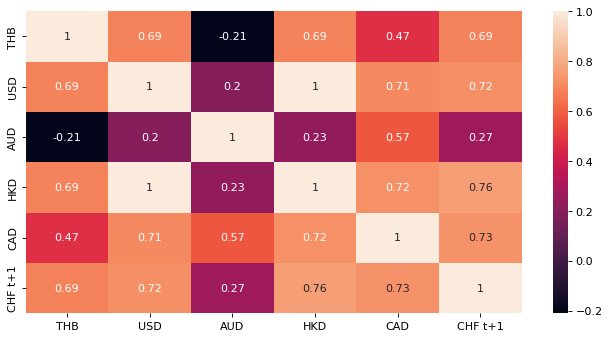

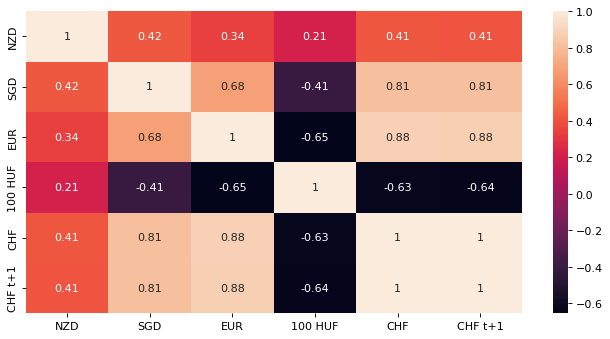

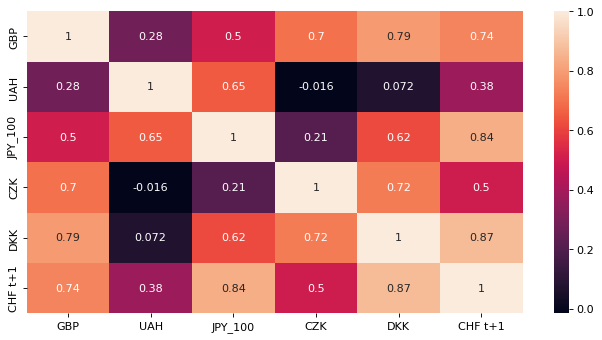

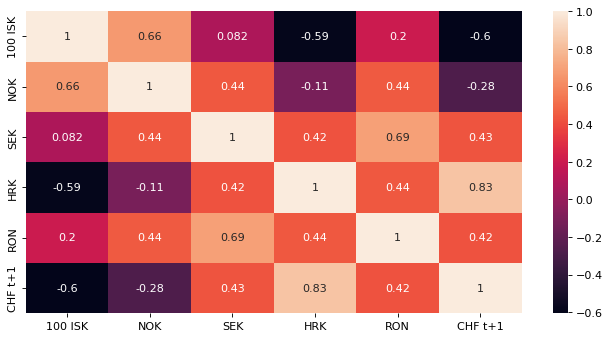

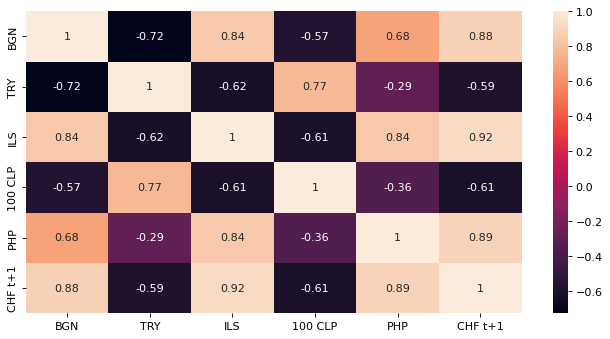

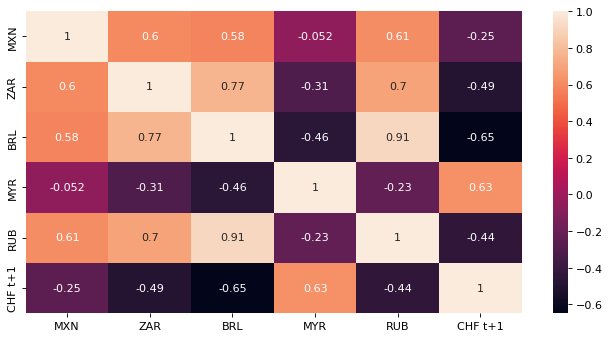

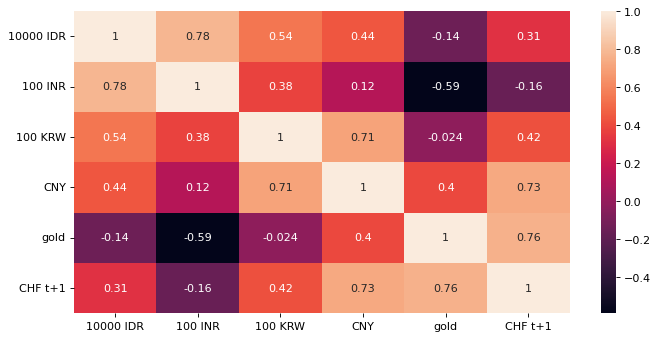

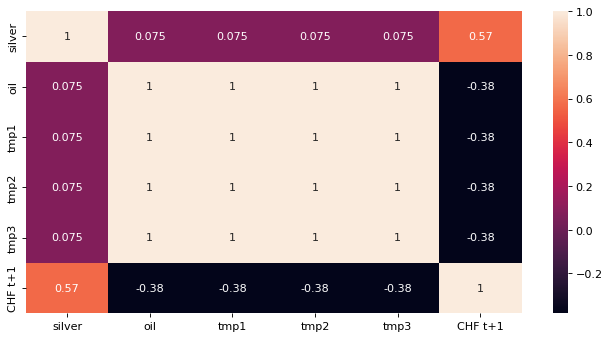

In [20]:
tmp = resources_currency_1_before.copy()
tmp = tmp.astype(float)
tmp['tmp1'] = tmp['oil']
tmp['tmp2'] = tmp['oil']
tmp['tmp3'] = tmp['oil']
chf = tmp[["CHF t+1"]].reset_index(drop=True)
tmp = tmp.drop(columns = ["CHF t+1"]).reset_index(drop=True)
for i in range(5, 41, 5):
    plt.figure(figsize=(10,5), dpi= 80)
    x = tmp.iloc[:, i-5:i]
    x['CHF t+1'] = chf
    sns.heatmap(x.corr(), annot=x.corr())

just natural resources

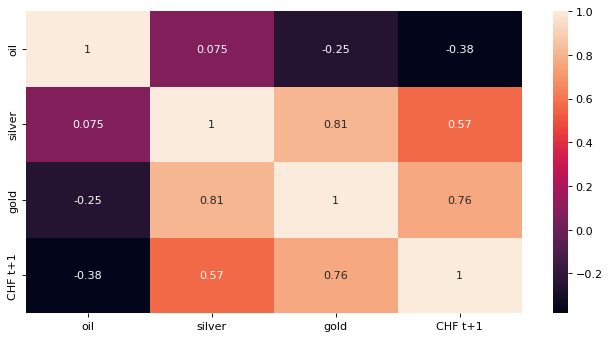

In [21]:
tmp = resources_currency_1_before[['oil', 'silver', 'gold', 'CHF t+1']]
plt.figure(figsize=(10,5), dpi= 80)
sns.heatmap(tmp.corr(), annot=tmp.corr())
plt.savefig('surowce_t1.png')

### t+7

C:\Users\konra\AppData\Local\Temp/ipykernel_19864/1793786731.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['CHF t+7'] = chf


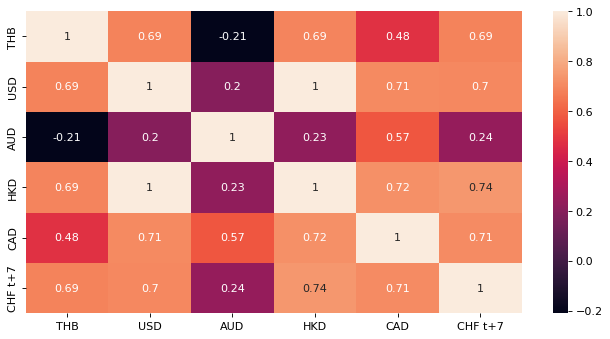

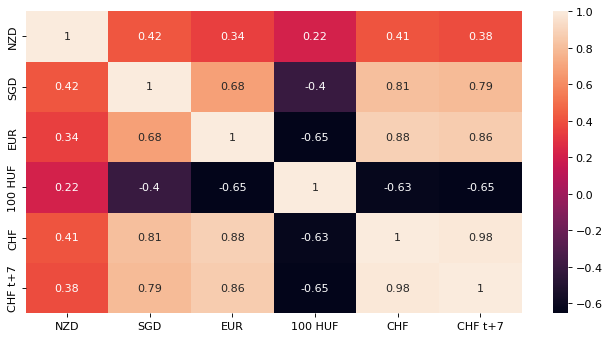

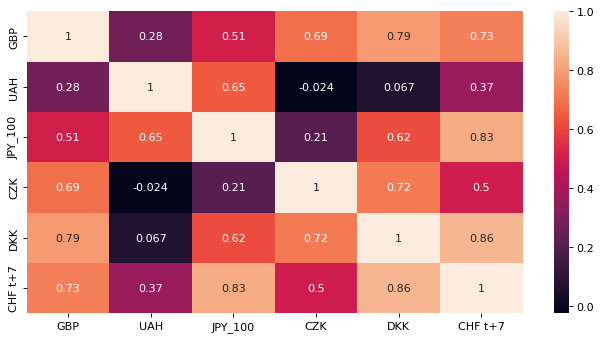

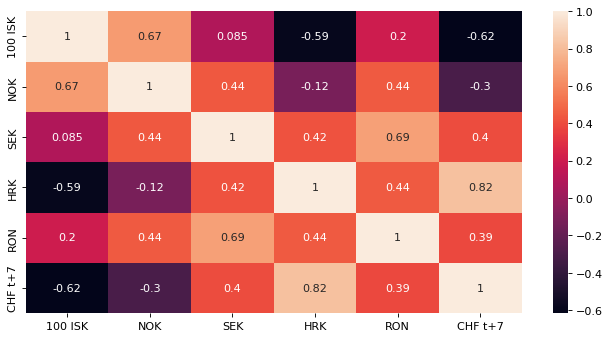

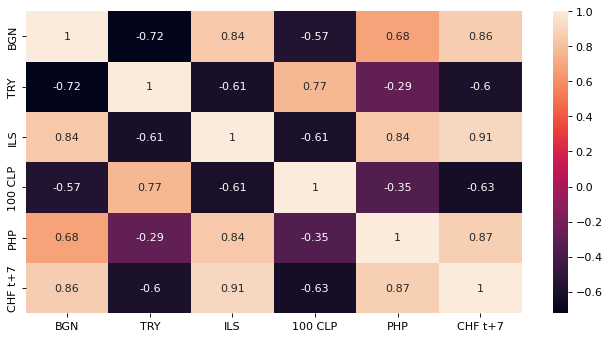

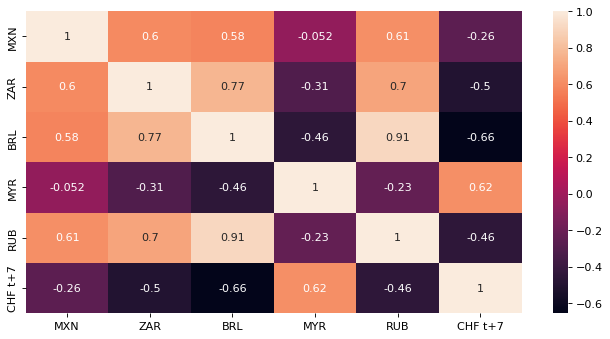

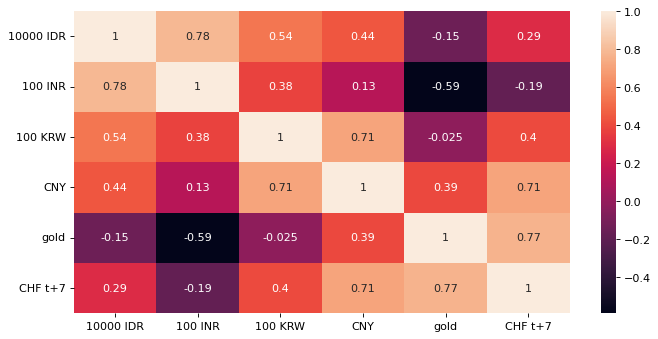

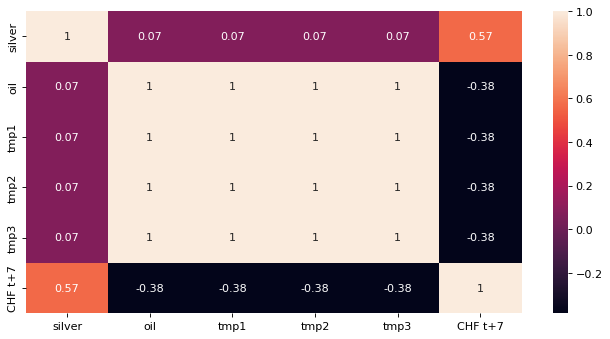

In [22]:
tmp = resources_currency_7_before.copy()
tmp = tmp.astype(float)
tmp['tmp1'] = tmp['oil']
tmp['tmp2'] = tmp['oil']
tmp['tmp3'] = tmp['oil']
chf = tmp[["CHF t+7"]].reset_index(drop=True)
tmp = tmp.drop(columns = ["CHF t+7"]).reset_index(drop=True)
for i in range(5, 41, 5):
    plt.figure(figsize=(10,5), dpi= 80)
    x = tmp.iloc[:, i-5:i]
    x['CHF t+7'] = chf
    sns.heatmap(x.corr(), annot=x.corr())

just natural resources

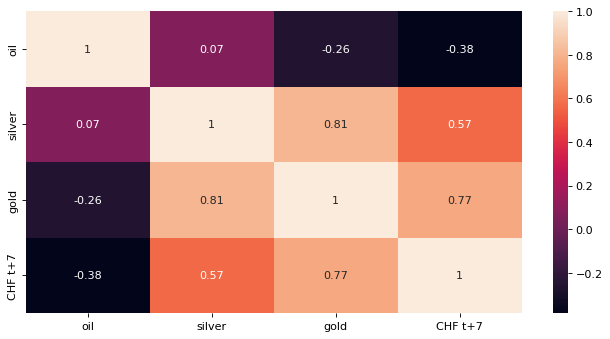

In [23]:
tmp = resources_currency_7_before[['oil', 'silver', 'gold', 'CHF t+7']]
plt.figure(figsize=(10,5), dpi= 80)
sns.heatmap(tmp.corr(), annot=tmp.corr())
plt.savefig('surowce_t7.png')

In [24]:
best_data_with_date = final_df[['ILS', 'PHP', 'BGN', 'EUR', 'DKK', 'JPY_100', 'HRK', 'SGD', 'HKD', 'GBP', 'CAD', 'USD']].reset_index(drop=True)

# LSTM 

In [40]:
def predict_with_LSTM(frame, y_cols, x_cols, epochs, ratio, title):
    y = frame.filter(y_cols)
    x = frame.filter(selected_columns)
    dataset = y.values
    input_dataset = x.values
    factors = x.shape[1]
    
    # Get the number of rows to train the model on
    training_data_len = int(np.ceil( len(dataset) * ratio ))
    
    # Scale the data
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_input_dataset = scaler.fit_transform(input_dataset)
    scaled_data = scaler.fit_transform(dataset)
    
    # Create the training data set 
    # Create the scaled training data set
    train_data = scaled_data[0:int(training_data_len), :]
    train_input = scaled_input_dataset[0:int(training_data_len), :]
    # Split the data into x_train and y_train data sets
    x_train = []
    y_train = []

    for i in range(60, len(train_data)):
        x_train.append(train_input[i-59:i+1])
        y_train.append(train_data[i, 0])

    # Convert the x_train and y_train to numpy arrays 
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1]*factors, 1))
    
    
        ##########
    # Create the testing data set
    # Create a new array containing scaled values from index 1543 to 2002 
    test_data = scaled_input_dataset[training_data_len - 60: , :]
    # Create the data sets x_test and y_test
    x_test = []
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-59:i+1])

    # Convert the data to a numpy array
    x_test = np.array(x_test)


    # Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1]*factors, 1 ))

    #get y_test
    y_test = dataset[int(training_data_len):]
    
    
    
    
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

    #early stop
    early_stop = EarlyStopping(monitor='val_mean_squared_error', patience=150, mode = 'min', restore_best_weights=True)
    
    #batch_size
    BATCH_SIZE = 4
    
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=epochs,
                        validation_split=0.1, validation_batch_size=BATCH_SIZE, shuffle = False, callbacks=[early_stop])
              
              
              
              
    #, validation_data=(x_test, y_test))
    # visualizing losses and accuracy
    
    print(history.history.keys())
    train_loss = history.history['loss']
    val_loss   = history.history['val_loss']
    train_acc = history.history['mean_squared_error']
    val_acc = history.history['val_mean_squared_error']
    xc         = range(epochs)
    plt.figure(figsize=(16,6))
#     plt.plot(xc, train_loss)
#     plt.show()
#     plt.figure(figsize=(16,6))
#     plt.plot(xc, val_loss)
#     plt.show()
    #plt.show()
    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    

    # Get the models predicted price values 
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    print("predictions shape:", predictions.shape)
    # Get the root mean squared error (RMSE)
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    mape = mean_absolute_percentage_error(y_test, predictions)

    
    # Plot the data
    train = frame[:training_data_len]
    print("train shape:", train.shape)
    valid = frame[training_data_len:]
    print("valid shape:", valid.shape)
    valid['Predictions'] = predictions
    valid
    #Visualize the data
    plt.figure(figsize=(16,6))
    plt.title(title)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price ' + y_cols[0], fontsize=18)
    #plt.plot(train['CHF'])
    plt.plot(valid[[y_cols[0], 'Predictions']])
    plt.legend(['Val', 'Predictions'], loc='lower right') #'Train'
    plt.show()
    print("RMSE: ", rmse)
    print("MAPE: ", mape)
    return rmse, mape

# Predictions

## Predicting CHF on day t+1 basing on exchange rate (CHF) from day t

Epoch 1/500
217/217 [==============================] - 7s 26ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 2/500
217/217 [==============================] - 5s 24ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 3/500
217/217 [==============================] - 5s 23ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 4/500
217/217 [==============================] - 5s 24ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0136 - val_mean_squared_error: 0.0136
Epoch 5/500
217/217 [==============================] - 5s 24ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 6/500
217/217 [==============================] - 5s 23ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0159 - val_mean_squared_error: 0.0159
Epoch 7/500
217/

Epoch 51/500
217/217 [==============================] - 5s 23ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 52/500
217/217 [==============================] - 5s 23ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 53/500
217/217 [==============================] - 5s 23ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 54/500
217/217 [==============================] - 5s 23ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 55/500
217/217 [==============================] - 5s 23ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 56/500
217/217 [==============================] - 5s 23ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 57/5

217/217 [==============================] - 5s 23ms/step - loss: 8.2010e-04 - mean_squared_error: 8.2010e-04 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 149/500
217/217 [==============================] - 5s 23ms/step - loss: 7.9799e-04 - mean_squared_error: 7.9799e-04 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 150/500
217/217 [==============================] - 5s 23ms/step - loss: 8.5956e-04 - mean_squared_error: 8.5956e-04 - val_loss: 9.8862e-04 - val_mean_squared_error: 9.8862e-04
Epoch 151/500
217/217 [==============================] - 5s 23ms/step - loss: 5.5801e-04 - mean_squared_error: 5.5801e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 152/500
217/217 [==============================] - 5s 23ms/step - loss: 5.9074e-04 - mean_squared_error: 5.9074e-04 - val_loss: 7.8719e-04 - val_mean_squared_error: 7.8719e-04
Epoch 153/500
217/217 [==============================] - 5s 23ms/step - loss: 5.3062e-04 - mean_squared_error: 5.3062e-04 - val_

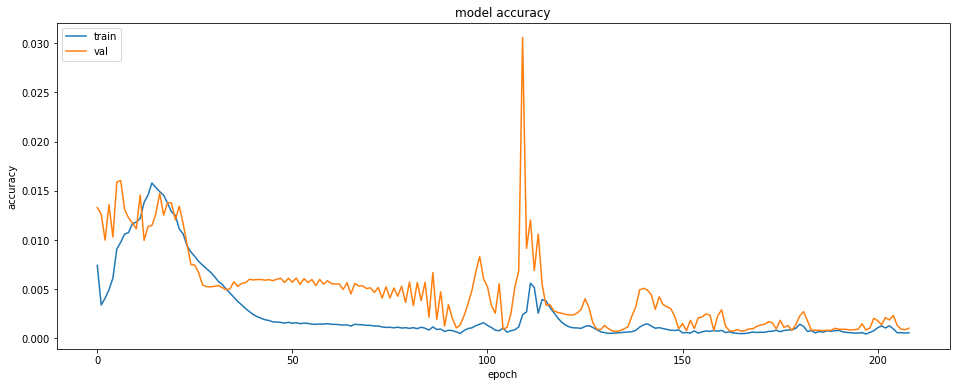

predictions shape: (180, 1)
train shape: (1022, 38)
valid shape: (180, 38)


C:\Users\konra\AppData\Local\Temp/ipykernel_13740/3150222643.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


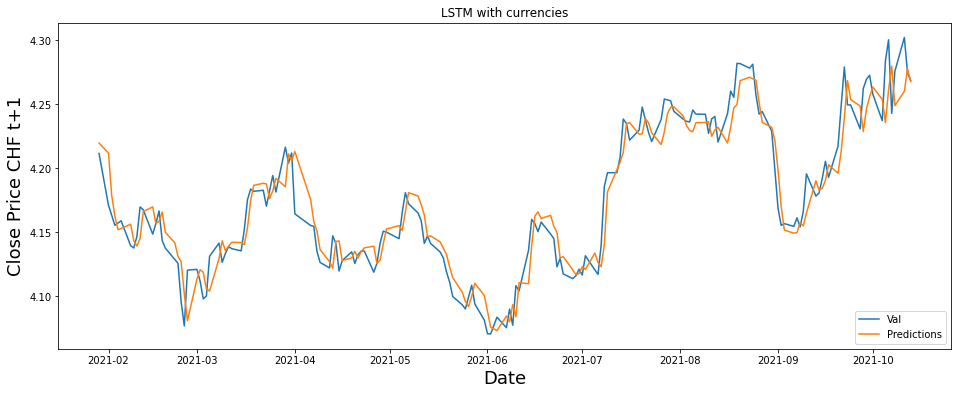

RMSE:  0.016852940150220975
MAPE:  0.0031645097335416613


(0.016852940150220975, 0.0031645097335416613)

In [161]:
selected_columns = ['CHF'] #CHF 
predict_with_LSTM(resources_currency_1_before,['CHF t+1'], selected_columns, 500, 0.85, 'LSTM with currencies')

## Predicting CHF on day t+1 basing on exchange rate (ILS, BGN, EUR, USD, JPY, CHF) from day t

Epoch 1/500
217/217 [==============================] - 43s 187ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 2/500
217/217 [==============================] - 49s 225ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 3/500
217/217 [==============================] - 44s 203ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 4/500
217/217 [==============================] - 46s 213ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 5/500
217/217 [==============================] - 45s 206ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Epoch 6/500
217/217 [==============================] - 45s 206ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoc

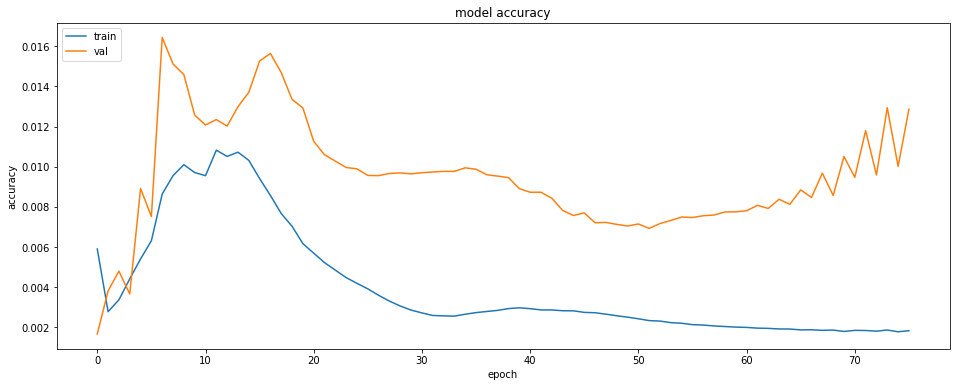

predictions shape: (180, 1)
train shape: (1022, 38)
valid shape: (180, 38)


C:\Users\konra\AppData\Local\Temp/ipykernel_13740/3150222643.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


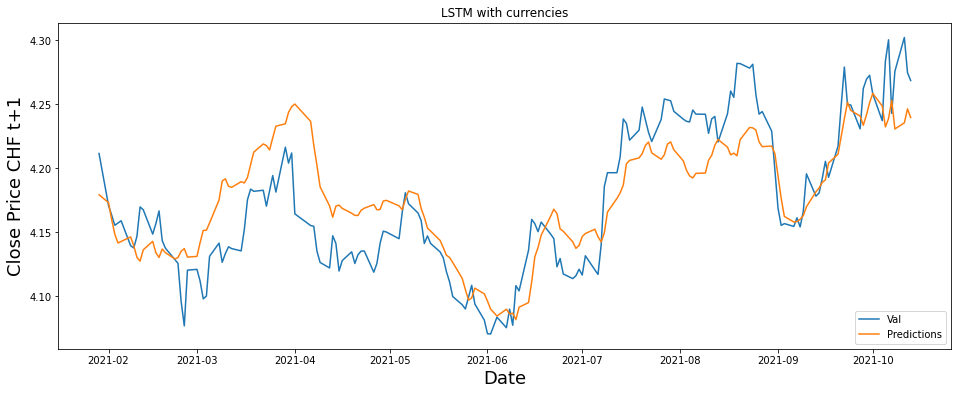

RMSE:  0.032116990567278396
MAPE:  0.0063613497014221795


(0.032116990567278396, 0.0063613497014221795)

In [166]:
selected_columns = ['ILS', 'BGN', 'EUR', 'USD', 'JPY_100', 'CHF'] #CHF 
predict_with_LSTM(resources_currency_1_before,['CHF t+1'], selected_columns, 500, 0.85, 'LSTM with currencies')

## Predicting CHF on day t+7 basing on exchange rate (CHF) from day t

Epoch 1/500
216/216 [==============================] - 8s 28ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0163 - val_mean_squared_error: 0.0163
Epoch 2/500
216/216 [==============================] - 6s 26ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 3/500
216/216 [==============================] - 5s 25ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0119 - val_mean_squared_error: 0.0119
Epoch 4/500
216/216 [==============================] - 5s 25ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0105 - val_mean_squared_error: 0.0105
Epoch 5/500
216/216 [==============================] - 5s 25ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0202 - val_mean_squared_error: 0.0202
Epoch 6/500
216/216 [==============================] - 5s 25ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0167 - val_mean_squared_error: 0.0167
Epoch 7/500
216/

Epoch 51/500
216/216 [==============================] - 6s 26ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 52/500
216/216 [==============================] - 5s 25ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 53/500
216/216 [==============================] - 5s 25ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 54/500
216/216 [==============================] - 5s 25ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 55/500
216/216 [==============================] - 5s 25ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 56/500
216/216 [==============================] - 5s 25ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 57/5

216/216 [==============================] - 6s 26ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 101/500
216/216 [==============================] - 5s 25ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 102/500
216/216 [==============================] - 5s 25ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 103/500
216/216 [==============================] - 5s 25ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 104/500
216/216 [==============================] - 5s 25ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 105/500
216/216 [==============================] - 5s 25ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 106/500
216/

216/216 [==============================] - 5s 25ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 150/500
216/216 [==============================] - 5s 25ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 151/500
216/216 [==============================] - 5s 25ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 152/500
216/216 [==============================] - 5s 25ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 153/500
216/216 [==============================] - 5s 25ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 154/500
216/216 [==============================] - 5s 25ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 155/500
216/

216/216 [==============================] - 5s 25ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 199/500
216/216 [==============================] - 5s 25ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 200/500
216/216 [==============================] - 5s 25ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 201/500
216/216 [==============================] - 5s 25ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 202/500
216/216 [==============================] - 5s 25ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 203/500
216/216 [==============================] - 5s 25ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 204/500
216/

216/216 [==============================] - 5s 25ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 248/500
216/216 [==============================] - 6s 26ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 249/500
216/216 [==============================] - 6s 27ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 250/500
216/216 [==============================] - 7s 30ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 251/500
216/216 [==============================] - 7s 31ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 252/500
216/216 [==============================] - 6s 29ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 253/500
216/

216/216 [==============================] - 5s 25ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 297/500
216/216 [==============================] - 5s 25ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 298/500
216/216 [==============================] - 5s 25ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 299/500
216/216 [==============================] - 5s 25ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 300/500
216/216 [==============================] - 6s 26ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 301/500
216/216 [==============================] - 5s 25ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 302/500
216/

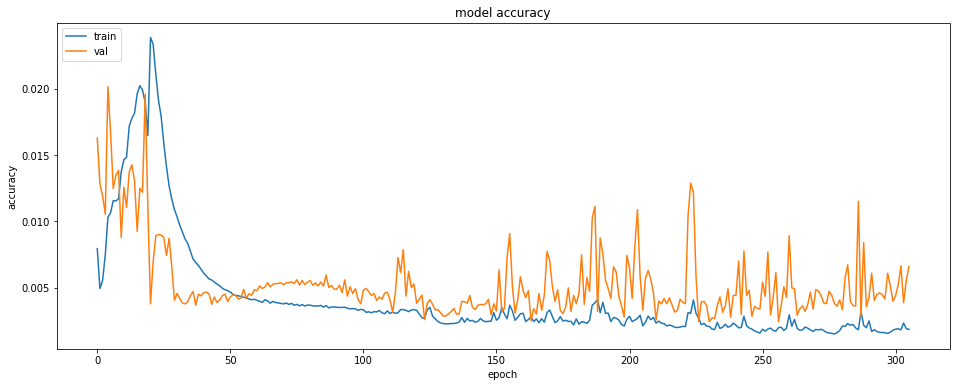

predictions shape: (179, 1)
train shape: (1019, 38)
valid shape: (179, 38)


C:\Users\konra\AppData\Local\Temp/ipykernel_19864/3150222643.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


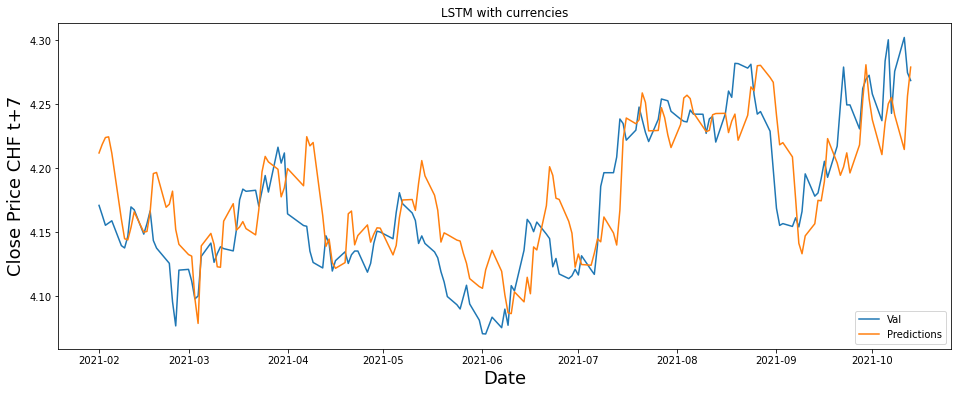

RMSE:  0.0356843482461123
MAPE:  0.006777648707311806


(0.0356843482461123, 0.006777648707311806)

In [30]:
selected_columns = ['CHF'] #CHF 
predict_with_LSTM(resources_currency_7_before,['CHF t+7'], selected_columns, 500, 0.85, 'LSTM with currencies')

## Predicting CHF on day t+7 basing on exchange rate (ILS, BGN, EUR, USD, JPY, CHF) from day t

Epoch 1/500
216/216 [==============================] - 39s 172ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 2/500
216/216 [==============================] - 36s 168ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 3/500
216/216 [==============================] - 37s 170ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 4/500
216/216 [==============================] - 48s 224ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0125 - val_mean_squared_error: 0.0125
Epoch 5/500
216/216 [==============================] - 45s 208ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0169 - val_mean_squared_error: 0.0169
Epoch 6/500
216/216 [==============================] - 46s 212ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0188 - val_mean_squared_error: 0.0188
Epoc

216/216 [==============================] - 34s 159ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 51/500
216/216 [==============================] - 34s 158ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0109 - val_mean_squared_error: 0.0109
Epoch 52/500
216/216 [==============================] - 34s 159ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0107 - val_mean_squared_error: 0.0107
Epoch 53/500
216/216 [==============================] - 35s 163ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 54/500
216/216 [==============================] - 34s 155ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 55/500
216/216 [==============================] - 33s 155ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 56/50

216/216 [==============================] - 33s 151ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 100/500
216/216 [==============================] - 32s 150ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 101/500
216/216 [==============================] - 32s 150ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0122 - val_mean_squared_error: 0.0122
Epoch 102/500
216/216 [==============================] - 34s 155ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0129 - val_mean_squared_error: 0.0129
Epoch 103/500
216/216 [==============================] - 34s 157ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 104/500
216/216 [==============================] - 34s 156ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 

Epoch 148/500
216/216 [==============================] - 34s 157ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0231 - val_mean_squared_error: 0.0231
Epoch 149/500
216/216 [==============================] - 34s 156ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0252 - val_mean_squared_error: 0.0252
Epoch 150/500
216/216 [==============================] - 34s 157ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0171 - val_mean_squared_error: 0.0171
Epoch 151/500
216/216 [==============================] - 34s 156ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0191 - val_mean_squared_error: 0.0191
Epoch 152/500
216/216 [==============================] - 34s 157ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0193 - val_mean_squared_error: 0.0193
Epoch 153/500
216/216 [==============================] - 34s 156ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0173 - val_mean_squared_error:

Epoch 197/500
216/216 [==============================] - 34s 158ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0333 - val_mean_squared_error: 0.0333
Epoch 198/500
216/216 [==============================] - 36s 166ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 199/500
216/216 [==============================] - 34s 159ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 200/500
216/216 [==============================] - 34s 156ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 201/500
216/216 [==============================] - 34s 156ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 202/500
216/216 [==============================] - 34s 156ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0086 - val_mean_squared_error:

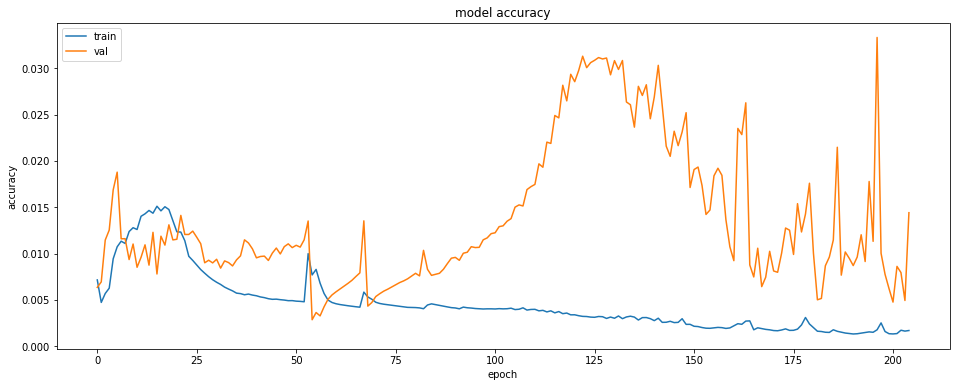

predictions shape: (179, 1)
train shape: (1019, 38)
valid shape: (179, 38)


C:\Users\konra\AppData\Local\Temp/ipykernel_19864/3599192907.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


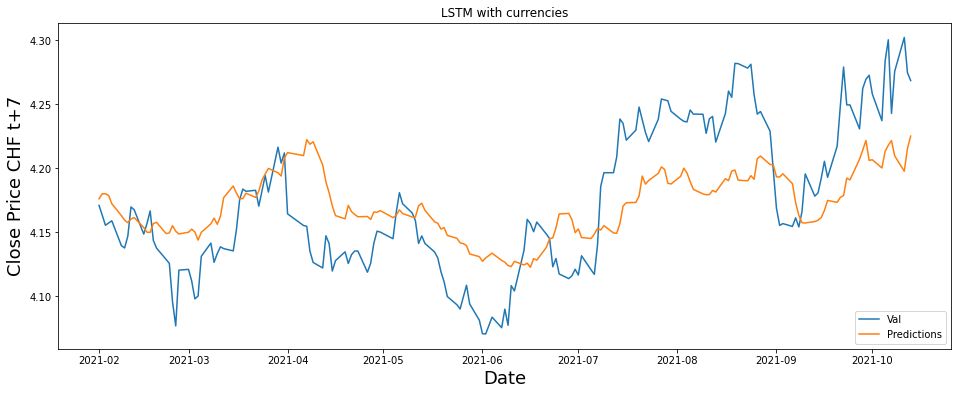

RMSE:  0.04335496504225253
MAPE:  0.008863602650637036


(0.04335496504225253, 0.008863602650637036)

In [41]:
selected_columns = ['ILS', 'BGN', 'EUR', 'USD', 'JPY_100', 'CHF'] #CHF 
predict_with_LSTM(resources_currency_7_before,['CHF t+7'], selected_columns, 500, 0.85, 'LSTM with currencies')